# O4

## iFood classifier

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))

print('Tensorflow version: ',tf.__version__)
print('Keras version: ',tf.keras.__version__,end='\n\n')

Num GPUs Available:  1
GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version:  2.8.0
Keras version:  2.8.0



In [2]:
# Setting up the use for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [3]:
batchSize = 40
imgHeight = 180
imgWidth = 180

dir = os.getcwd()
trainPath = dir+'\\Data6Classes\\train'
print(trainPath)

X_train = tf.keras.utils.image_dataset_from_directory(trainPath,labels='inferred',label_mode='int',\
	color_mode='rgb',seed=15,batch_size=batchSize,image_size=(imgHeight,imgWidth),validation_split=0.2,subset="training")
X_val = tf.keras.utils.image_dataset_from_directory(trainPath,labels='inferred',label_mode='int',\
	color_mode='rgb',seed=15,batch_size=batchSize,image_size=(imgHeight,imgWidth),validation_split=0.2,subset="validation")
class_names = X_train.class_names
class_number = len(X_train.class_names)
print(f"Classes: {class_names}")
print(f"Number of classes: {class_number}")

c:\Users\Rasmus\Github\SWMAL_15_O4\Data6Classes\train
Found 2743 files belonging to 6 classes.
Using 2195 files for training.
Found 2743 files belonging to 6 classes.
Using 548 files for validation.
Classes: ['brisket_126', 'edamame_76', 'hamburger_164', 'lobster_food_91', 'omelette_196', 'pizza_183']
Number of classes: 6


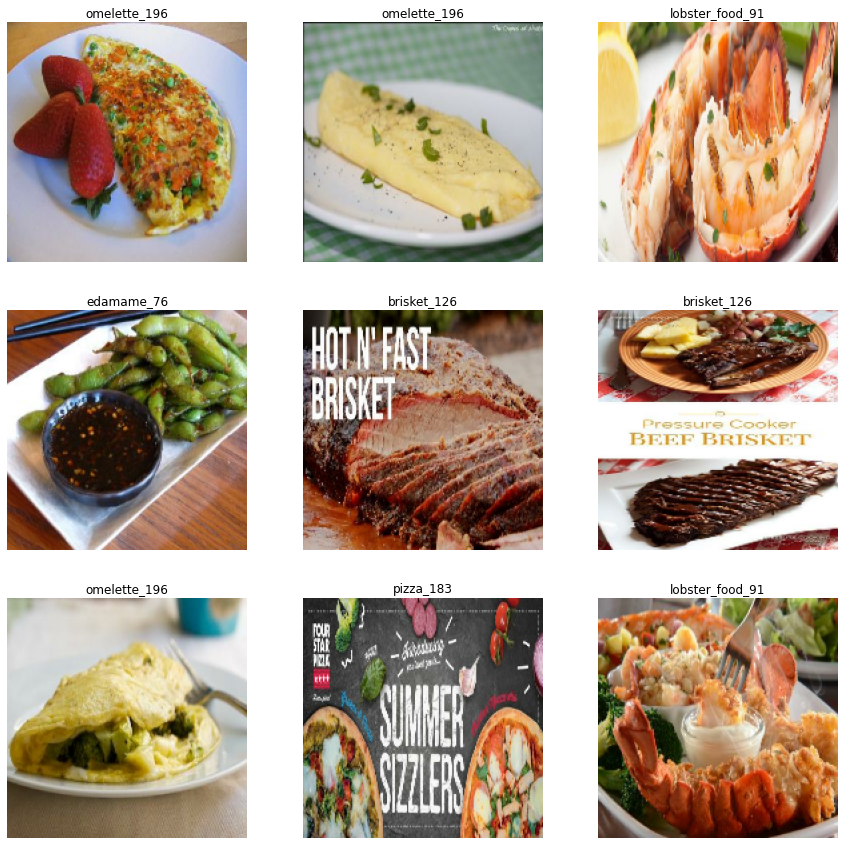

In [4]:
plt.figure(figsize=(15, 15))
for images, labels in X_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [5]:
for image_batch, labels_batch in X_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(40, 180, 180, 3)
(40,)


In [6]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_X_train = X_train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_X_train))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.016971039 1.0


Model: "iFood6_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 174, 174, 64)      9472      
                                                                 
 MPool1 (MaxPooling2D)       (None, 58, 58, 64)        0         
                                                                 
 Conv2 (Conv2D)              (None, 54, 54, 64)        102464    
                                                                 
 MPool2 (MaxPooling2D)       (None, 27, 27, 64)        0         
                                                                 
 Conv3 (Conv2D)              (None, 25, 25, 32)        18464     
                                                                 
 MPool3 (MaxPooling2D)       (None, 12, 12, 32)        0         
                                                                 
 Flatten (Flatten)           (None, 4608)              0

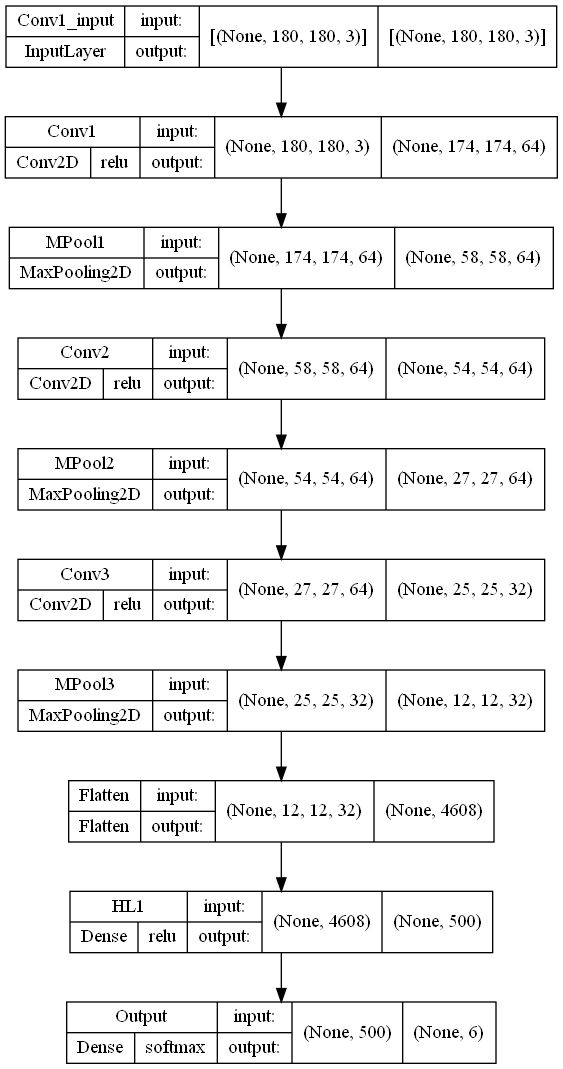

In [7]:
model = tf.keras.models.Sequential([
	tf.keras.layers.Conv2D(64, (7,7), activation="relu", input_shape=(imgHeight,imgWidth,3), name="Conv1"),
	tf.keras.layers.MaxPool2D((3,3), name="MPool1"),
    tf.keras.layers.Conv2D(64, (5,5), activation="relu", name="Conv2"),
    tf.keras.layers.MaxPool2D((2,2), name="MPool2"),
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", name="Conv3"),
    tf.keras.layers.MaxPool2D((2,2), name="MPool3"),
    tf.keras.layers.Flatten(name="Flatten"),
    tf.keras.layers.Dense(500,activation="relu",name="HL1"),
    tf.keras.layers.Dense(class_number,activation="softmax",name="Output"),
],name="iFood6_CNN")

print(model.summary())
tf.keras.utils.plot_model(model, to_file='iFood6_CNN_Model.png', show_shapes=True, show_layer_activations=True)

In [ ]:
class MyLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
	def __init__(self, initial_learning_rate):
		self.initial_learning_rate = initial_learning_rate
	def __call__(self, step):
		return self.initial_learning_rate / (step + 1)

epochs = 1000

lossfx = tf.losses.SparseCategoricalCrossentropy()
optimizerfx = tf.optimizers.Adam(learning_rate=MyLRSchedule(1e-3))

model.compile(loss=lossfx, optimizer=optimizerfx, metrics=["accuracy"])

In [8]:
# Fit model with GPU
with tf.device('/gpu:0'):
	startTime = time.time()
	history = model.fit(X_train, validation_data=X_val, epochs=epochs)
	endTime = time.time()

timeStr = f'{round((endTime-startTime)/3600)} hr, {round((endTime-startTime)/60)%60} min, {(endTime-startTime)%60} sec'
print(timeStr)

Epoch 1/1000
55/55 [==============================] - 6s 76ms/step - loss: 35.7445 - accuracy: 0.2369 - val_loss: 2.6870 - val_accuracy: 0.2646
Epoch 2/1000
55/55 [==============================] - 4s 67ms/step - loss: 2.3018 - accuracy: 0.2979 - val_loss: 2.3984 - val_accuracy: 0.2828
Epoch 3/1000
55/55 [==============================] - 4s 68ms/step - loss: 2.1087 - accuracy: 0.3139 - val_loss: 2.2583 - val_accuracy: 0.3011
Epoch 4/1000
55/55 [==============================] - 4s 68ms/step - loss: 2.0006 - accuracy: 0.3399 - val_loss: 2.1819 - val_accuracy: 0.3193
Epoch 5/1000
55/55 [==============================] - 4s 67ms/step - loss: 1.9242 - accuracy: 0.3558 - val_loss: 2.1193 - val_accuracy: 0.3303
Epoch 6/1000
55/55 [==============================] - 4s 67ms/step - loss: 1.8665 - accuracy: 0.3704 - val_loss: 2.0724 - val_accuracy: 0.3449
Epoch 7/1000
55/55 [==============================] - 4s 67ms/step - loss: 1.8163 - accuracy: 0.3845 - val_loss: 2.0316 - val_accuracy: 0.344

In [23]:
timeStr = f'{round((endTime-startTime)/3600)} hr, {round((endTime-startTime)/60)%60} min, {(endTime-startTime)%60} sec'
print(timeStr)

1 hr, 3 min, 22.4735689163208 sec


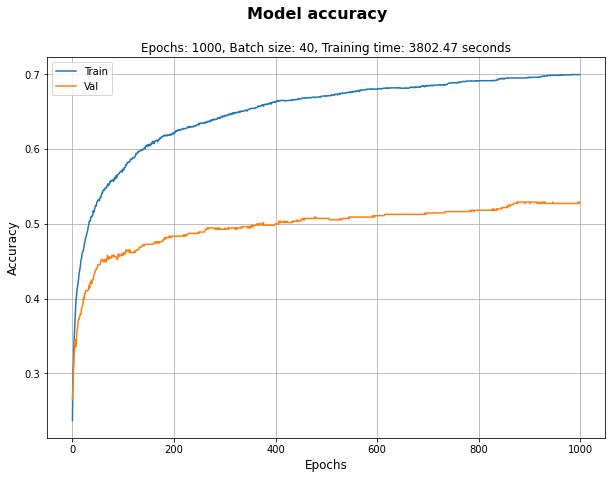

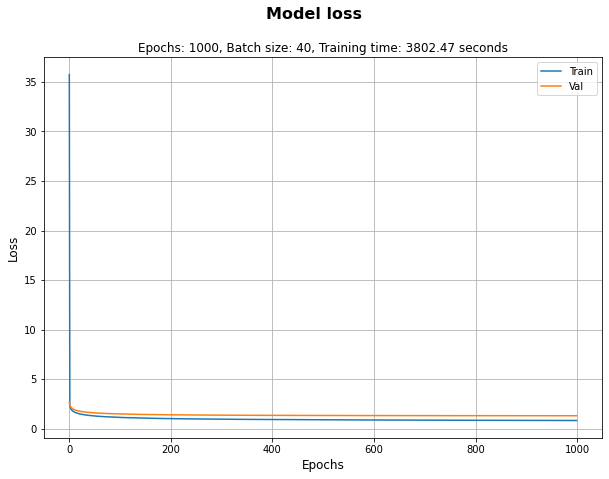

In [9]:
# Plot the accuracy of the model
plt.figure(101,figsize=(10,7),facecolor='white')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.suptitle('Model accuracy',fontweight='bold',fontsize=16)
plt.title(f'Epochs: {epochs}, Batch size: {batchSize}, Training time: {endTime-startTime:.2f} seconds')
plt.ylabel('Accuracy',fontsize=12)
plt.xlabel('Epochs',fontsize=12)
plt.legend(['Train','Val'])
plt.grid()
plt.savefig(f'Model_accuracy_{epochs}_{batchSize}.png')
plt.show()

# Plot the loss of the model
plt.figure(102,figsize=(10,7),facecolor='white')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.suptitle('Model loss',fontweight='bold',fontsize=16)
plt.title(f'Epochs: {epochs}, Batch size: {batchSize}, Training time: {endTime-startTime:.2f} seconds')
plt.ylabel('Loss',fontsize=12)
plt.xlabel('Epochs',fontsize=12)
plt.legend(['Train','Val'])
plt.grid()
plt.savefig(f'Model_loss_{epochs}_{batchSize}.png')
plt.show()

In [10]:
imgHeight = 180
imgWidth = 180

dir = os.getcwd()
testPath = dir+'\\Data6Classes\\test'
print(testPath)

X_test = tf.keras.utils.image_dataset_from_directory(trainPath,labels='inferred',label_mode='int',\
	color_mode='rgb',seed=15,image_size=(imgHeight,imgWidth))

results = model.evaluate(X_test)
print(results)

c:\Users\Rasmus\Github\SWMAL_15_O4\Data6Classes\test
Found 2743 files belonging to 6 classes.
86/86 [==============================] - 2s 24ms/step - loss: 0.9237 - accuracy: 0.6657
[0.9236639738082886, 0.6656944751739502]


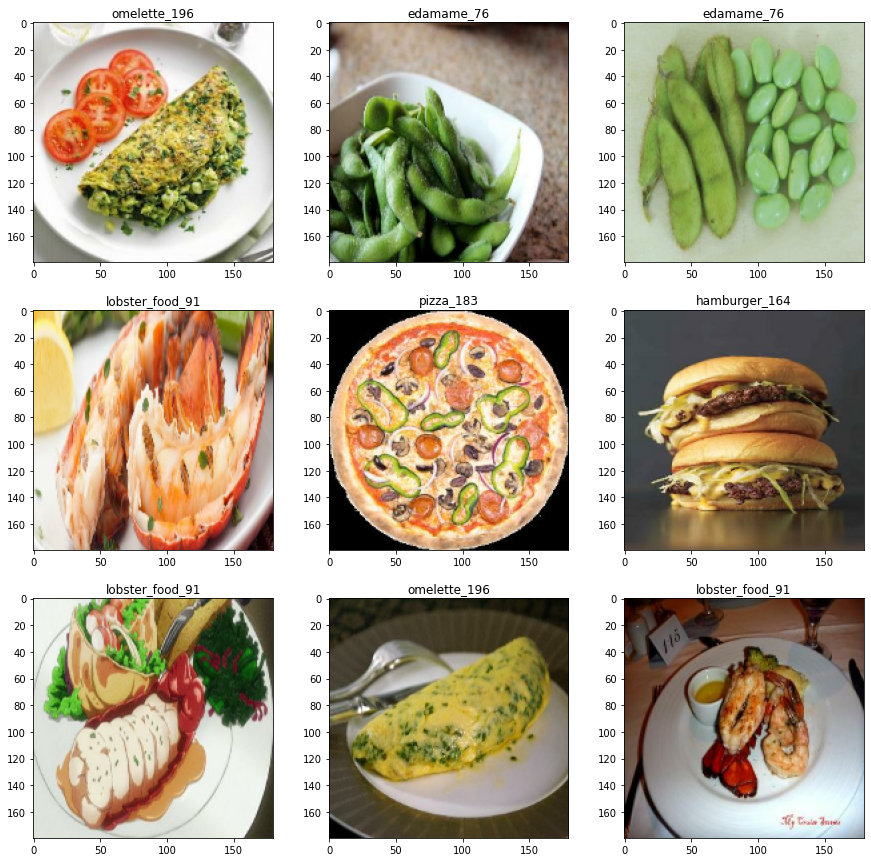

In [11]:
predictions = model.predict(X_test)
image_batch, labels_batch = next(iter(X_test))

plt.figure(figsize=(15, 15))
for i in range(9):
	plt.subplot(3, 3, i + 1)
	plt.imshow(image_batch[i].numpy().astype('uint8'))
	plt.title(class_names[labels_batch[i]])
plt.show()

In [17]:
model.save(f'iFood6_CNN_Model_{epochs}_{batchSize}')

INFO:tensorflow:Assets written to: iFood6_CNN_Model_1000_40\assets


INFO:tensorflow:Assets written to: iFood6_CNN_Model_1000_40\assets


NotImplementedError: Learning rate schedule must override get_config